# $\text{Jane Street Market Prediction}$

## $\text{Getting the data}$

## For Oscar:

In [20]:
# Data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) #arbitrary large number, I wanna see all columns


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#utilities
import os
from collections import Counter

In [21]:
%%time
working_dir = "/Users/oscarengelbrektson/Documents/Minerva/Spring 2021 - San Francisco/Quantitative Trading/Jane Street Competition/data/"

train_data = pd.read_csv(working_dir + "train.csv")
test_data_sample = pd.read_csv(working_dir + "example_test.csv")
feature_data = pd.read_csv(working_dir + "features.csv")


CPU times: user 57 s, sys: 10 s, total: 1min 6s
Wall time: 1min 11s


## For Taha

In [1]:
# getting access to Google Drive to retrieve data
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# changing the working directory
#%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [3]:
'''
!kaggle competitions download -c jane-street-market-prediction
!unzip \*.zip  && rm *.zip''';

In [7]:
%%time
train_data = pd.read_csv('C:/Users/Taha/Desktop/Spring 2021/JaneStreet/train.csv')

Wall time: 2min 7s


In [9]:
# difference columns between train and test set
#set(train_data.columns) - set(test_sample.columns)

## $\text{LightGMB}$

### $\text{Data Processing}$

In [22]:
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))

In [23]:
cropped_train_data = train_data.loc[train_data.date > 85]

In [25]:
#Take 350 dates as training, and 64 as validation
validation_set = cropped_train_data[train_data.date > 350 + 85]
train_set = cropped_train_data[train_data.date <= 350 + 85]

train_set.date.nunique(), validation_set.date.nunique()

<ipython-input-25-2548ba76df17>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  validation_set = cropped_train_data[train_data.date > 350 + 85]
<ipython-input-25-2548ba76df17>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_set = cropped_train_data[train_data.date <= 350 + 85]


(350, 64)

In [26]:
# percentage of trades in the test set
round(100*validation_set.shape[0] / (train_data.shape[0]), 2)

14.39

In [27]:
predictors = list(set(train_data.columns) - {'resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'action', 'ts_id'})
outcome = ['action']

### $\text{LightGBM: One Split}$

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import lightgbm as lgb

In [29]:
X_train, X_validation, y_train, y_validation = train_set[predictors],  validation_set[predictors], train_set[outcome], validation_set[outcome]

LGBMClassifier()

### $\text{Hyperparameter Tunning: Bayesian Optimization}$

In [33]:
def lgbm_cv(learning_rate, num_leaves, 
            min_data_in_leaf, max_bin,
            max_depth):
    
    estimator_function = lgb.LGBMClassifier(max_depth=int(max_depth),
                                            learning_rate = learning_rate,
                                            num_leaves = int(num_leaves),
                                            min_data_in_leaf = int(min_data_in_leaf),
                                            max_bin=int(max_bin),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)
    
    estimator_function.fit(X_train, y_train.values.reshape(len(y_train),))
    probs = estimator_function.predict_proba(X_validation)[:,1]
    return roc_auc_score(y_validation, probs)

In [34]:
from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

hp_space = {'learning_rate': (0.001, 0.1),
          'num_leaves': (100, 300),
          'min_data_in_leaf': (5, 20),
          'max_bin': (150, 250),
          'max_depth': (2, 15)}

lgbcBO = BayesianOptimization(f=lgbm_cv, pbounds=hp_space, random_state=42, verbose=-1)

In [35]:
lgbcBO.maximize(init_points=5, n_iter=20, acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  1        |  0.5222   |  0.03808  |  245.1    |  11.52    |  13.98    |  131.2    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  2        |  0.5194   |  0.01644  |  155

|  17       |  0.5182   |  0.01722  |  160.1    |  5.093    |  18.68    |  259.0    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  18       |  0.5194   |  0.07797  |  185.8    |  12.89    |  19.02    |  132.6    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  19       |  0.5227   |  0.05106  |  201.2    |  12.29    |  9.956    |  284.5    |
[LightGBM] [Warning] num_threads is set with

In [36]:
#Best accuracy:
lgbcBO.max["target"]

0.5268441051319724

In [37]:
best_params = lgbcBO.max["params"]
best_params

{'learning_rate': 0.09073187147889872,
 'max_bin': 160.5356704543628,
 'max_depth': 3.914569092358141,
 'min_data_in_leaf': 18.879331315667216,
 'num_leaves': 254.14088082966137}

# Compute utility score depending on decision threshold'

In [38]:
y_pred_probs = lgb_model.predict_proba(X_validation)

In [39]:
validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1

<ipython-input-39-9d3c100330eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1


In [40]:
def utility_score_last(date, weight, resp, action):
    '''
    Takes four 1-d arrays of equal size:
    Date: int
    weight: float >= 0
    resp: float
    action: binary
    
    and returns jane street utility score, u
    '''
    count_i = date.nunique() # Get number of days
    P_i = np.bincount(date, weight * resp * action) # Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) # Combine to get utility score
    return u

def get_utility_from_df(df, decision_threshold=0.5):
    '''
    Takes a dataframe and a decision threshold, 
    computes the total utility given the decision threshold for converting predicted probabilities to actions
    '''
    return utility_score_last(df.date, df.weight, df.resp, 
                              df.lgbm_predicted_prob.apply(lambda proba: int(proba > decision_threshold)))

In [41]:
thresholds =  np.linspace(0, 1, 200)
utility_by_threshold = [get_utility_from_df(validation_set, threshold) for threshold in thresholds]


<ipython-input-40-1f5466e7d848>:13: RuntimeWarning: invalid value encountered in double_scalars
  t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t


In [42]:
best_threshold = thresholds[utility_by_threshold.index(max(utility_by_threshold))]

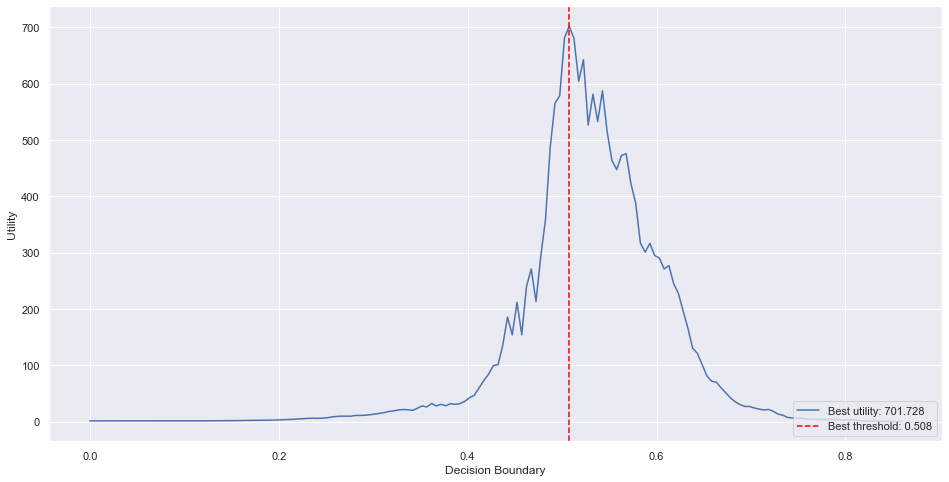

In [43]:
# Visualize
plt.figure(figsize=(16, 8))
plt.plot(thresholds, utility_by_threshold, label="Best utility: %s"%np.round(max(utility_by_threshold), 3))
plt.axvline(best_threshold, 
            color="red", linestyle="--",label="Best threshold: %s"%np.round(best_threshold, 3))
plt.ylabel("Utility")
plt.xlabel("Decision Boundary")
plt.legend(loc=4)
plt.show()

# Compute test set utility

In [100]:
import janestreet
env = janestreet.make_env()
env_iter = env.iter_validation()

ModuleNotFoundError: No module named 'janestreet.competition'